In [4]:
import rasterio
import os
#import kelp_tools as kt
import pickle
import numpy as np
from rasterio.errors import RasterioIOError
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import clear_output
import matplotlib.dates as mdates
import re
from pyproj import Transformer
from tools import data_tools as dt
from scipy.stats import linregress
import matplotlib.ticker as ticker
from pyproj import Transformer

In [5]:
def convert_df_types(df, col_types=None):
    if col_types is None:
        col_types = {
            'kelp_pixels': int,
            'day_num': float,
            'mesma': float,
            'tide': float,
            'clouds': float,
            'current': float,
            'cloud_correction_factor': float,
            'date': 'datetime'
        }
    for col, dtype in col_types.items():
        if dtype == 'datetime':
            if not pd.api.types.is_datetime64_any_dtype(df[col]):
                df[col] = pd.to_datetime(df[col], format="%Y-%m-%dT%H:%M:%S.%f", errors='coerce')
        else:
            df[col] = df[col].astype(dtype)
    return df


def get_stats(array):
    return np.mean(array), np.std(array), np.percentile(array, [25, 75])

def get_pair_change(df, category=None):
    mesma_change = []
    if category is None:
        category = 'mesma'
    for i, pair in df.iterrows():
        if(pair[f'f_{category}'] > pair[f's_{category}']):
            high_pixel =  pair[f'f_{category}']
            low_pixel =  pair[f's_{category}']
        else:
            low_pixel =  pair[f'f_{category}']
            high_pixel = pair[f's_{category}']
        mean = float((high_pixel+low_pixel)/2)
        if(mean == 0 ):
            percent_change= 0
        else:
            percent_change = float(2*(high_pixel-low_pixel)/(low_pixel + high_pixel))
        change = high_pixel-low_pixel
        mesma_change.append([low_pixel,high_pixel,mean,percent_change, change])
    mesma_change=np.stack(mesma_change)
    return mesma_change

def get_mesma_pixel_sums(path, file1, file2, mesma_residuals=False, crop=False, bands=[5,6], only_overlap=False, kelp_map=None):
    f_data = dt.load_processed_img(path,file1, bands=bands, geo_info=False,cloud_coverage=True, crop=crop, date_return=True)
    if f_data is None:
        return None
    #print(f_data)
    f_img, f_daynum, f_date, f_tide, f_current, f_clouds = f_data
    s_data = dt.load_processed_img(path,file2, bands=bands, geo_info=False,cloud_coverage=True, crop=crop, date_return=True)
    if s_data is None:
        return None
    s_img, s_daynum, s_date, s_tide, s_current, s_clouds = s_data
    # if crop:
    #     s_img = s_img[:,2800:3050,850:1600]
    #     f_img = f_img[:,2800:3050,850:1600]
    
    # Process First Image
    f_mesma = np.array(f_img[1])
    #f_mesma = np.where(f_mesma < 5, 0 , f_mesma)
    #f_mesma = np.where(f_mesma > 200, 0, f_mesma)

    # if only_overlap:
    #     f_mesma = np.where(s_img[0] == 0, f_mesma, 0)
    #     f_mesma = np.where(f_img[0] == 0, f_mesma, 0)
    # else:
    #     f_mesma = np.where(s_img[0] == 2, 0, f_mesma)

    f_kelp = np.where(f_img[0] == 0, 1, 0)
    # f_kelp = np.where(s_img[0] == 2, 0, f_kelp)

    f_cloud_correction_factor = None
    if kelp_map is not None:
        f_mesma = np.where(kelp_map, f_mesma, 0)
        f_kelp = np.where(kelp_map, f_kelp,0)
        cloud_over_kelp = np.where(f_img[0] == 2,kelp_map, 0)
        clouds_over_kelp_sum = np.sum(cloud_over_kelp)
        kelp_pixels = np.sum(kelp_map)
        f_cloud_correction_factor = (kelp_pixels/(kelp_pixels-clouds_over_kelp_sum)).astype(float)

    f_kelp_pixels = np.sum(f_kelp)
    f_sum = np.sum(f_mesma)
    # # Process Second Image
    s_mesma = np.array(s_img[1])
    # s_mesma = np.where(s_mesma < 5, 0 , s_mesma)
    # s_mesma = np.where(s_mesma > 200, 0, s_mesma)

    f_clouds = np.sum(np.where(f_img[0] ==2, 1, 0))
    s_clouds = np.sum(np.where(s_img[0] ==2,1,0))


    if only_overlap:
        s_mesma = np.where(f_img[0] == 0, s_mesma, 0)
        s_mesma = np.where(s_img[0] == 0, s_mesma, 0)
    else:
        s_mesma = np.where(f_img[0] == 2, 0, s_mesma)

    s_kelp = np.where(s_img[0] == 0, 1, 0)
    # s_kelp = np.where(f_img[0] == 2, 0, s_kelp)
    s_cloud_correction_factor= None
    if kelp_map is not None:
        s_mesma = np.where(kelp_map, s_mesma, 0)
        s_kelp = np.where(kelp_map, s_kelp,0)
        cloud_over_kelp = np.where(s_img[0] == 2,kelp_map, 0)
        clouds_over_kelp_sum = np.sum(cloud_over_kelp)
        if(kelp_pixels - clouds_over_kelp_sum == 0):
            s_cloud_correction_factor = 999
        else:
            s_cloud_correction_factor = (kelp_pixels/(kelp_pixels-clouds_over_kelp_sum)).astype(float)

    s_kelp_pixels = np.sum(s_kelp)
    s_sum = np.sum(s_mesma)
    #print(s_sum)
    
    data = [file1, f_daynum, f_sum, f_kelp_pixels,f_current,f_tide,f_clouds,f_cloud_correction_factor, file2, s_daynum,s_sum,s_kelp_pixels,s_current,s_tide, s_clouds, s_cloud_correction_factor]
    if mesma_residuals:
        mesma_res = f_mesma - s_mesma
        return data , mesma_res, f_mesma, s_mesma
    return data


In [7]:
version =7
path = rf'H:\HLS_data\imagery\Isla_vista_kelp\processed_v{version}\11SKU'
filenames = os.listdir(path)
pairs = dt.group_by_date(filenames, max_days=3, max_pair_size=2)
print(f'Pairs found: {len(pairs)}')

data_array_v4 = []
kelp_map = dt.load_processed_img("H:\HLS_data\imagery\Isla_vista_kelp\processed_v4", 'kelp_map.tif', bands=[1], crop=True, just_data=True)
kelp_map = kelp_map[0]
for pair in pairs:
    files = pair[1]
    data = dt.get_mesma_pixel_sums(path, files[0], files[1], crop=True, only_overlap=False, kelp_map=kelp_map)
    #print(data)
    if data is not None:
        data_array_v4.append(data)

data_array_stacked_v4 =np.stack(data_array_v4)
df_v4 = pd.DataFrame(data_array_stacked_v4, columns=dt.get_col_keys())

Pairs found: 96
HLS.S30.T11SKU.2021051T184409.v2.0_processed.tif has no TIDE or CURRENT metadata


c:\Users\attic\HLS Kelp Detection\data_tools.py:166: RuntimeWarning: divide by zero encountered in scalar divide
  f_cloud_correction_factor = (kelp_pixels/(kelp_pixels-clouds_over_kelp_sum)).astype(float)


HLS.S30.T11SKU.2022226T183919.v2.0_processed.tif has no TIDE or CURRENT metadata
HLS.S30.T11SKU.2023041T184519.v2.0_processed.tif has no TIDE or CURRENT metadata


In [ ]:
print(df_v4.head())

In [8]:
col_types = {
    'f_date': float,
    'f_mesma': float,
    'f_kelp_pixels': int,
    'f_current': float,
    'f_tide': float,
    'f_clouds': float,
    'f_cloud_factor': float,
    's_date': float,
    's_mesma': float,
    's_kelp_pixels': int,
    's_current': float,
    's_tide': float,
    's_clouds': float,
    's_cloud_factor': float
}

In [9]:
df_v4 = convert_df_types(df_v4,col_types=col_types)

In [10]:
df_v4_fltr = df_v4[(df_v4['f_cloud_factor'] <= 1.5) & (df_v4['s_cloud_factor'] <= 1.5)]
def calculate_cloud_cover_percent(row):
    val1 = (1 - 1 / row['f_cloud_factor']) * 100
    val2 = (1 - 1 / row['s_cloud_factor']) * 100
    return np.max([val1, val2])

df_v4['cloud_cover_percent'] = df_v4.apply(calculate_cloud_cover_percent, axis=1)


In [11]:
def plot_pair_values(df, show_color=False, color_basis='', color_title='', title1='Image 1',  title2='Image 2', single_color_var=False, vmin=None, vmax=None):
    f_mesma = df['f_mesma'].astype(int)
    s_mesma= df['s_mesma'].astype(int)
    f_kelp = df['f_kelp_pixels'].astype(int)
    s_kelp= df['s_kelp_pixels'].astype(int)

    # Calculating cloud cover percent (your previous task)
    df['cloud_cover_percent'] = df.apply(lambda row: np.max([(1 - 1 / row['f_cloud_factor']) * 100, (1 - 1 / row['s_cloud_factor']) * 100]), axis=1)

    # Assuming show_color, single_color_var, color_basis, vmin, vmax, color_title, title1, title2 are define
    # Handling colors
    if show_color:
        if single_color_var and color_basis != '':
            colors = df[color_basis].astype(float)
        elif color_basis == '':
            colors = df['f_clouds'].astype(float) - df['s_clouds'].astype(float)
        else:
            colors = df[f'{color_basis}'].astype(float)
        if vmin is None:
            vmin = np.min(colors)
        if vmax is None:
            vmax = np.max(colors)

    # Best fit line and R^2 for mesma
    slope_mesma, intercept_mesma, r_value_mesma, p_value_mesma, std_err_mesma = linregress(f_mesma, s_mesma)
    y_fit_mesma = slope_mesma * np.linspace(f_mesma.min(), f_mesma.max(), 100) + intercept_mesma

    # Best fit line and R^2 for kelp
    slope_kelp, intercept_kelp, r_value_kelp, p_value_kelp, std_err_kelp = linregress(f_kelp, s_kelp)
    y_fit_kelp = slope_kelp * np.linspace(f_kelp.min(), f_kelp.max(), 100) + intercept_kelp

    # Plotting
    plt.figure(figsize=(18, 6))

    # Mesma plot
    plt.subplot(1, 2, 1)
    if show_color:
        scatter_1 = plt.scatter(f_mesma, s_mesma, c=colors, vmin=vmin, vmax=vmax, alpha=1, label=f'R²={r_value_mesma**2:.2f}')
    else:
        scatter_1 = plt.scatter(f_mesma, s_mesma, alpha=1, label=f'R²={r_value_mesma**2:.2f}')
    plt.plot(np.linspace(f_mesma.min(), f_mesma.max(), 100), np.linspace(f_mesma.min(), f_mesma.max(), 100), color='red', label='y = x')
    #plt.plot(np.linspace(f_mesma.min(), f_mesma.max(), 100), y_fit_mesma, color='blue', linestyle='--', label=f'Fit: y={slope_mesma:.2f}x+{intercept_mesma:.2f}, R²={r_value_mesma**2:.2f}')
    # cbar = plt.colorbar(scatter_1)
    # cbar.ax.tick_params(labelsize=14)  # Set the font size for colorbar ticks
    # cbar.set_label(color_title, fontsize=16)
    plt.legend(fontsize=16)
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))  
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6)) 
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylim((0,100000))
    plt.xlim((0,100000))
    plt.gca().tick_params(axis='y', which='major', pad=10)  # Adjust 'pad' value as needed
    plt.gca().tick_params(axis='x', which='major', pad=10)  # Adjust 'pad' value as needed
    plt.xlabel("Image 1 (MESMA Kelp Value)", fontsize=16)
    plt.ylabel("Image 2 (MESMA Kelp Value)", fontsize=16)
    plt.title('Mesma Value Comparison', fontsize=22)

    # Kelp plot
    plt.subplot(1, 2, 2)
    if show_color:
        scatter_2 = plt.scatter(f_kelp, s_kelp, c=colors, vmin=vmin, vmax=vmax, alpha=1, label=f'R²={r_value_kelp**2:.2f}')
    else:
        scatter_2 = plt.scatter(f_kelp, s_kelp, alpha=1, label=f'R²={r_value_kelp**2:.2f}')
    plt.plot(np.linspace(f_kelp.min(), f_kelp.max(), 100), np.linspace(f_kelp.min(), f_kelp.max(), 100), color='red', label='y = x')
    #plt.plot(np.linspace(f_kelp.min(), f_kelp.max(), 100), y_fit_kelp, color='blue', linestyle='--', label=f'Fit: y={slope_kelp:.2f}x+{intercept_kelp:.2f}, R²={r_value_kelp**2:.2f}')
    cbar = plt.colorbar(scatter_2)
    cbar.ax.tick_params(labelsize=14)  # Set the font size for colorbar ticks
    cbar.set_label(color_title, fontsize=16)
    plt.legend(fontsize=16)
    plt.xlabel("Image 1 (Number of Pixels) ", fontsize=16)
    plt.ylabel("Image 2 (Number of Pixels)", fontsize=16)
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))  # Adjust 'nbins' value as needed
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6)) 
    plt.title('Kelp Pixel Count Comparison', fontsize=22)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.gca().tick_params(axis='y', which='major', pad=10)  # Adjust 'pad' value as needed
    plt.gca().tick_params(axis='x', which='major', pad=10)  # Adjust 'pad' value as needed
    plt.show()

    # Print the slope, intercept, and R² values
    print(f"Mesma: slope = {slope_mesma}, intercept = {intercept_mesma}, R² = {r_value_mesma**2}")
    print(f"Kelp: slope = {slope_kelp}, intercept = {intercept_kelp}, R² = {r_value_kelp**2}")

In [12]:
df_v4 = convert_df_types(df_v4,col_types=col_types)

In [13]:
df_v4_fltr = df_v4[(df_v4['f_cloud_factor'] <= 1.2) & (df_v4['s_cloud_factor'] <= 1.2)]
df_v4_fltr_2 = df_v4_fltr[(df_v4_fltr['f_mesma'] > 200) & (df_v4_fltr['s_mesma'] > 200)]

In [14]:
change_array = get_pair_change(df_v4_fltr_2, category='kelp_pixels') #low_pixel,high_pixel,mean,percent_change, change

In [15]:
avg, std, quartile = get_stats(change_array[:,3])
print(avg, std, quartile)
#np.mean(array), np.std(array), np.percentile(array, [25, 75])

0.31510962554001654 0.3075903697526693 [0.11155063 0.3935743 ]


50


C:\Users\attic\AppData\Local\Temp\ipykernel_26584\322605111.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cloud_cover_percent'] = df.apply(lambda row: np.max([(1 - 1 / row['f_cloud_factor']) * 100, (1 - 1 / row['s_cloud_factor']) * 100]), axis=1)


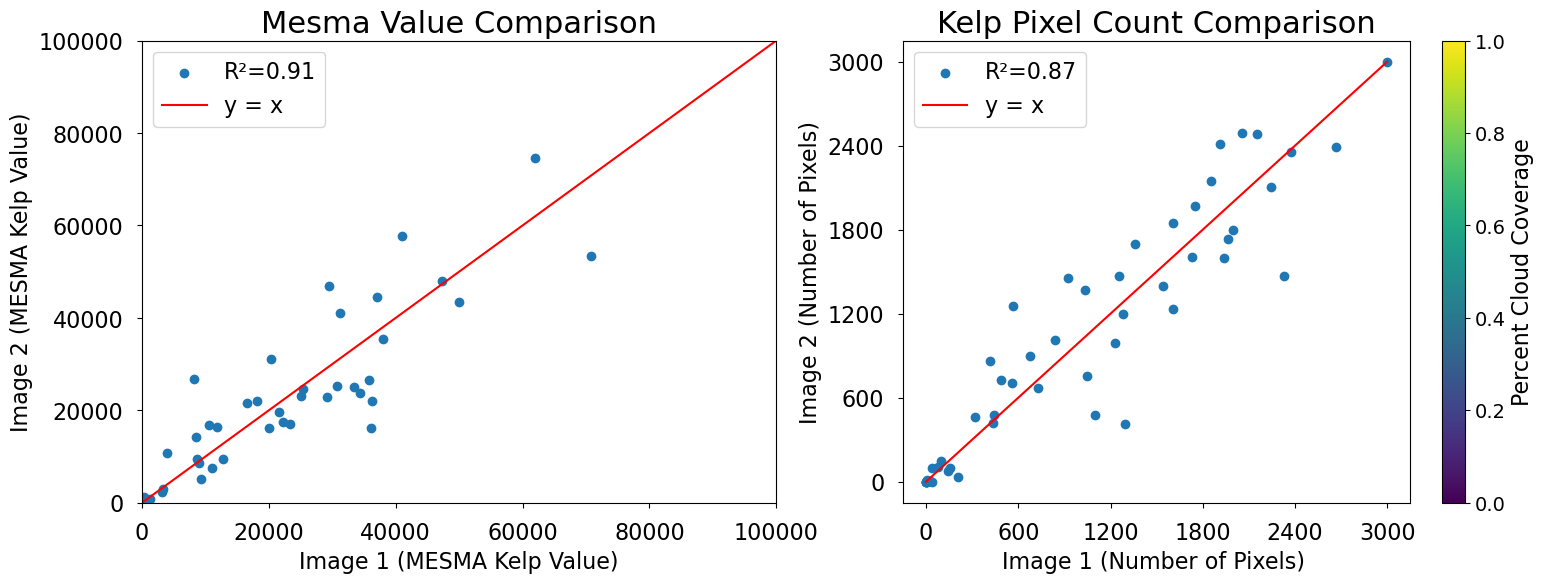

Mesma: slope = 0.9607965062175673, intercept = 771.7529289769591, R² = 0.9123372359331474
Kelp: slope = 0.9412285108435845, intercept = 68.8099321119754, R² = 0.8743764811390538


In [16]:
print(len(df_v4_fltr))
plot_pair_values(df_v4_fltr, title1='Image 1', title2='Image 2', show_color=False, color_basis='cloud_cover_percent', single_color_var=True, color_title='Percent Cloud Coverage')

In [17]:
def plot_tide_current(df):
    # Assuming df is your DataFrame
    current_diff = df['f_current'] - df['s_current']
    mesma_hc = np.where(current_diff > 0, df['f_mesma'], df['s_mesma'])
    mesma_lc = np.where(current_diff <= 0, df['f_mesma'], df['s_mesma'])
    current_diff = abs(current_diff)
    mesma_diff_current = (mesma_lc - mesma_hc) / mesma_hc

    tide_diff = df['f_tide'] - df['s_tide']
    mesma_ht = np.where(tide_diff > 0, df['f_mesma'], df['s_mesma'])
    mesma_lt = np.where(tide_diff <= 0, df['f_mesma'], df['s_mesma'])
    tide_diff = abs(tide_diff)
    mesma_diff_tide = (mesma_lt - mesma_ht) / mesma_ht

    valid_indices_tide = np.isfinite(mesma_diff_tide) & ~np.isnan(mesma_diff_tide)
    valid_indices_current = np.isfinite(mesma_diff_current) & ~np.isnan(mesma_diff_current)

    tide_diff_clean = tide_diff[valid_indices_tide]
    mesma_diff_tide_clean = mesma_diff_tide[valid_indices_tide] * 100

    current_diff_clean = current_diff[valid_indices_current]
    mesma_diff_current_clean = mesma_diff_current[valid_indices_current] * 100
    # print(tide_diff_clean)
    # print(mesma_diff_current_clean)
    # Check if there is variation in the data

    slope_tide, intercept_tide, r_value_tide, p_value_tide, std_err_tide = linregress(tide_diff_clean, mesma_diff_tide_clean)

    slope_current, intercept_current, r_value_current, p_value_current, std_err_current = linregress(current_diff_clean, mesma_diff_current_clean)

    plt.figure(figsize=(18, 6))

    # Plot for Tide Difference vs Kelp Detection
    plt.subplot(1, 2, 1)
    plt.title("Tide Vs Change in Kelp Detection", fontsize=20)
    plt.ylabel("Change in Kelp (%)", fontsize=16)
    plt.xlabel("Difference in Water Height (m) | (High - Low Tide)", fontsize=14)
    plt.scatter(tide_diff_clean, mesma_diff_tide_clean, label=f'R²={r_value_tide**2:.2f}')
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # if not np.isnan(r_value_tide):
    #     plt.plot(tide_diff_clean, intercept_tide + slope_tide * tide_diff_clean, 'r', label=f'Fit line, R²={r_value_tide**2:.2f}')
    #     plt.legend()

    # Plot for Current Difference vs Kelp Detection
    plt.subplot(1, 2, 2)
    plt.title("Current Vs Change in Kelp Detection", fontsize=20)
    plt.ylabel("Change in Kelp (%)", fontsize=16)
    plt.xlabel("Difference in Current Magnitude (m/s) | (High - Low Current)", fontsize=14)
    plt.scatter(current_diff_clean, mesma_diff_current_clean, label=f'R²={r_value_current**2:.2f}')
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # if not np.isnan(r_value_current):
    #     plt.plot(current_diff_clean, intercept_current + slope_current * current_diff_clean, 'r', label=f'Fit line, R²={r_value_current**2:.2f}')
    #     plt.legend()

    plt.show()


C:\Users\attic\AppData\Local\Temp\ipykernel_26584\924607870.py:7: RuntimeWarning: divide by zero encountered in divide
  mesma_diff_current = (mesma_lc - mesma_hc) / mesma_hc
C:\Users\attic\AppData\Local\Temp\ipykernel_26584\924607870.py:7: RuntimeWarning: invalid value encountered in divide
  mesma_diff_current = (mesma_lc - mesma_hc) / mesma_hc
C:\Users\attic\AppData\Local\Temp\ipykernel_26584\924607870.py:13: RuntimeWarning: divide by zero encountered in divide
  mesma_diff_tide = (mesma_lt - mesma_ht) / mesma_ht
C:\Users\attic\AppData\Local\Temp\ipykernel_26584\924607870.py:13: RuntimeWarning: invalid value encountered in divide
  mesma_diff_tide = (mesma_lt - mesma_ht) / mesma_ht


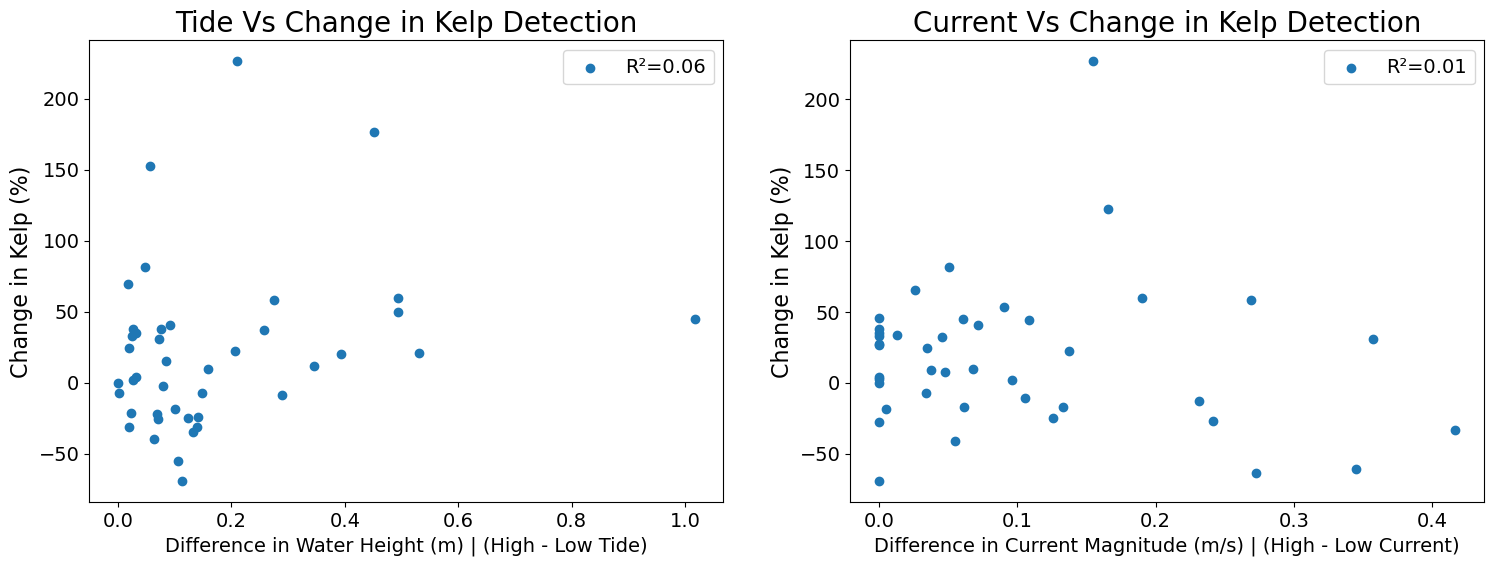

In [18]:
plot_tide_current(df_v4_fltr)

In [ ]:
print(data_array_v4[:5])  # Print the first 5 elements to verify their structure

column_keys = dt.get_col_keys()
print(len(column_keys))
print(data_array_stacked_v4.shape)

In [ ]:
print(dt.get_col_keys())

In [ ]:
version =6
path = rf'H:\HLS_data\imagery\Isla_vista_kelp\processed_v{version}\11SKU'
filenames = os.listdir(path)
pairs = dt.group_by_date(filenames, max_days=3, max_pair_size=2)
print(f'Pairs found: {len(pairs)}')

data_array = []
kelp_map = dt.load_processed_img("H:\HLS_data\imagery\Isla_vista_kelp\processed_v4", 'kelp_map.tif', bands=[1], crop=True, just_data=True)
kelp_map = kelp_map[0]
for pair in pairs:
    files = pair[1]
    data = dt.get_mesma_pixel_sums(path, files[0], files[1], crop=True, only_overlap=False, kelp_map=kelp_map)
    if data is not None:
        data_array.append(data)

data_array =np.stack(data_array)
df_v6 = pd.DataFrame(data_array, columns=dt.get_col_keys())

In [ ]:
version =5
path = rf'H:\HLS_data\imagery\Isla_vista_kelp\processed_v{version}\11SKU'
filenames = os.listdir(path)
pairs = dt.group_by_date(filenames, max_days=3, max_pair_size=2)
print(f'Pairs found: {len(pairs)}')

data_array = []
kelp_map = dt.load_processed_img("H:\HLS_data\imagery\Isla_vista_kelp\processed_v4", 'kelp_map.tif', bands=[1], crop=True, just_data=True)
kelp_map = kelp_map[0]
for pair in pairs:
    files = pair[1]
    data = dt.get_mesma_pixel_sums(path, files[0], files[1], crop=True, only_overlap=False, kelp_map=kelp_map)
    if data is not None:
        data_array.append(data)

data_array =np.stack(data_array)
df_v5 = pd.DataFrame(data_array, columns=dt.get_col_keys())

In [ ]:
print(df_v4)

In [ ]:
def get_extent(transform, width, height):
    return [
        transform[2], 
        transform[2] + width * transform[0], 
        transform[5] + height * transform[4], 
        transform[5]
    ]

In [ ]:
kelp_data, transform, crs = dt.load_processed_img("H:\HLS_data\imagery\Isla_vista_kelp\processed_v4", 'kelp_map.tif', bands=[1,2], crop=False, geo_info=True,tide_current=False,cloud_coverage=False)

binary_kelp = kelp_data[0]
kelp_map = kelp_data[1]
extent = get_extent(transform, kelp_map[1] ,kelp_map[2])
kelp_image = kelp_map[2700:3100, 800:1800]
binary_kelp_image = binary_kelp[2700:3100, 800:1800]
#image = kelp_mask[3,2800:3250, 875:1300]
    # Update the transform for the cropped image
new_transform = transform * rasterio.Affine.translation(800, 2700)
extent_kelp = get_extent(new_transform,1800-800,3100-2700)
transformer = Transformer.from_crs(crs, 'EPSG:4326', always_xy=True)

lon_min, lat_min = transformer.transform(extent_kelp[0], extent_kelp[2])
lon_max, lat_max = transformer.transform(extent_kelp[1], extent_kelp[3])
# Define the new extent in lat/lon
extent_latlon = [lon_min, lon_max, lat_min, lat_max]
#kelp_image = np.where(kelp_image > 5, kelp_image, np.nan)

plt.figure(figsize=(16,8))
plt.imshow(kelp_image, extent=extent_latlon, cmap='Blues_r')#, cmap='Greys_r')
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_facecolor('black')
cbar = plt.colorbar( shrink=.7)
cbar.ax.tick_params(labelsize=14)  # Set the font size for colorbar ticks
cbar.set_label('Counts', fontsize=20)
plt.title("Number Of Times each Pixel is Classified as Kelp", fontsize=30)
plt.ylabel("Latitude", fontsize=24)
plt.xlabel("Longitude", fontsize=24)
plt.xticks(fontsize=20)#,rotation=45)
plt.yticks(fontsize=20)
plt.show()

plt.figure(figsize=(16,8))
plt.imshow(binary_kelp_image, extent=extent_latlon, cmap='Blues_r')#, cmap='Greys_r')
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().set_facecolor('black')
# cbar = plt.colorbar( shrink=.7)
# cbar.ax.tick_params(labelsize=14)  # Set the font size for colorbar ticks
# cbar.set_label('Counts', fontsize=20)
plt.title("Binary Kelp Mask", fontsize=30)
plt.ylabel("Latitude", fontsize=24)
plt.xlabel("Longitude", fontsize=24)
plt.xticks(fontsize=20)#,rotation=45)
plt.yticks(fontsize=20)
plt.show()


In [ ]:
if False:
    kelp_map, summed_img = dt.sum_kelp(path,filenames,save=True, binary_threshold=15)
    kelp_map = np.where(summed_img > 15, 1,0)
    print(kelp_map.shape)
    plt.figure(figsize=(25,25))
    plt.imshow(kelp_map[0,2500:3600,200:1750])
    plt.show()
    plt.figure(figsize=(25,25))
    plt.imshow(summed_img[0,2500:3600,200:1750])
    plt.colorbar()
    plt.show()
    dt.save_kelp_map(path,kelp_map,summed_img, version)
    test_kelp_image =dt.load_processed_img(r'H:\HLS_data\imagery\Isla_vista_kelp\processed_v4', 'kelp_map.tif', bands=[1], crop=True, just_data=True)
    plt.figure()
    plt.imshow(test_kelp_image[0])
    plt.show()

In [ ]:
col_types = {
    'f_date': float,
    'f_mesma': float,
    'f_kelp_pixels': int,
    'f_current': float,
    'f_tide': float,
    'f_clouds': float,
    'f_cloud_factor': float,
    's_date': float,
    's_mesma': float,
    's_kelp_pixels': int,
    's_current': float,
    's_tide': float,
    's_clouds': float,
    's_cloud_factor': float
}

In [ ]:
#df_v4_5 = convert_df_types(df_v4,col_types=col_types)
# df_v6 = convert_df_types(df_v6,col_types=col_types)
# df_v5 = convert_df_types(df_v5,col_types=col_types)

df_v4['percent_change'] = 2 *(abs(df_v4['f_mesma'] - df_v4['s_mesma'])) / (df_v4['s_mesma'] + df_v4['f_mesma'])
#df_v5['percent_change'] = 2 *(abs(df_v4['f_mesma'] - df_v5['s_mesma'])) / (df_v5['s_mesma'] + df_v5['f_mesma'])
#df_v6['percent_change'] = 2 *(abs(df_v6['f_mesma'] - df_v6['s_mesma'])) / (df_v6['s_mesma'] + df_v6['f_mesma'])

df_v4['cloud_cover_percent'] = np.max((1-1/(df_v4['f_cloud_factor']))*100, (1-1/(df_v4['s_cloud_factor']))*100)

# df['f_date'] = [datetime.strptime(date_str[:26], "%Y-%m-%dT%H:%M:%S.%f") for date_str in df['f_date']]
# df['s_date'] = [datetime.strptime(date_str[:26], "%Y-%m-%dT%H:%M:%S.%f") for date_str in df['s_date']]
#filtered_df = df[(df['f_mesma'] <= 100000) & (df['s_mesma'] <= 100000)]
#filtered_df = filtered_df[(filtered_df['f_kelp_pixels'] <= 6000) & (filtered_df['s_kelp_pixels'] <= 6000)]

df_v4_fltr = df_v4[(df_v4['f_cloud_factor'] <= 1.5) & (df_v4['s_cloud_factor'] <= 1.5)]

#df_v5_fltr = df_v5[(df_v5['f_cloud_factor'] <= 1.5) & (df_v5['s_cloud_factor'] <= 1.5)]
#df_v6_fltr = df_v6[(df_v6['f_cloud_factor'] <= 1.5) & (df_v6['s_cloud_factor'] <= 1.5)]




In [ ]:
dt.plot_pair_values(df_v4, show_color=True, single_color_var=True color_basis='cloud_cover_percent',color_title='Cloud over Kelp Factor')
dt.plot_pair_values(df_v5, show_color=True, color_basis='cloud_factor', vmin=1, vmax=5,color_title='Cloud over Kelp Factor')
dt.plot_pair_values(df_v6, show_color=True, color_basis='cloud_factor', vmin=1, vmax=5,color_title='Cloud over Kelp Factor')

In [ ]:
def plot_tide_current(df):
    current_diff = df['f_current'] - df['s_current']
    mesma_hc = np.where(current_diff > 0, df['f_mesma'], df['s_mesma'])
    mesma_lc = np.where(current_diff <= 0, df['f_mesma'], df['s_mesma'])
    current_diff = abs(current_diff)
    mesma_diff_current = (mesma_lc - mesma_hc) / mesma_hc


    tide_diff = df['f_tide'] - df['s_tide']
    mesma_ht = np.where(tide_diff > 0, df['f_mesma'], df['s_mesma'])
    mesma_lt = np.where(tide_diff <= 0, df['f_mesma'], df['s_mesma'])
    tide_diff = abs(tide_diff)
    mesma_diff_tide = (mesma_lt - mesma_ht) / mesma_ht

    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1) 
    plt.title("Water Height difference vs Kelp Detection")
    plt.ylabel("Percent Change in MESMA Value")
    plt.xlabel("Difference in Water Height (m) | (High Tide - Low Tide)")
    plt.scatter(tide_diff, mesma_diff_tide*100, c=current_diff)
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.scatter(current_diff, mesma_diff_current*100, c=tide_diff)
    plt.ylabel("Percent Change MESMA Value")
    plt.xlabel("Difference in Current Magnitude (m/s) | (High Current - Low Current)")
    plt.colorbar()
    plt.show()


plot_tide_current(df_v4_fltr)

In [ ]:
def get_mesma_pair_change(df):
    mesma_change = []
    for i, pair in df.iterrows():
        if(pair['f_mesma'] > pair['s_mesma']):
            high_pixel =  pair['f_mesma']
            low_pixel =  pair['s_mesma']
        else:
            low_pixel =  pair['f_mesma']
            high_pixel = pair['s_mesma']
        mean = float((high_pixel+low_pixel)/2)
        if(mean == 0 ):
            percent_change= 0
        else:
            percent_change = float(2*(high_pixel-low_pixel)/(low_pixel + high_pixel))
        change = high_pixel-low_pixel
        mesma_change.append([low_pixel,high_pixel,mean,percent_change, change])
    mesma_change=np.stack(mesma_change)
    return mesma_change

mesma_change_v4 = get_mesma_pair_change(df_v4)#_fltr)
mesma_change_v5 = get_mesma_pair_change(df_v5)#_fltr)
mesma_change_v6 = get_mesma_pair_change(df_v6)#_fltr)

In [ ]:
def get_stats(array):
    return np.mean(array), np.std(array), np.percentile(array, [25, 75])

def get_mesma_pair_change(df):
    mesma_change = []
    for i, pair in df.iterrows():
        if(pair['f_mesma'] > pair['s_mesma']):
            high_pixel =  pair['f_mesma']
            low_pixel =  pair['s_mesma']
        else:
            low_pixel =  pair['f_mesma']
            high_pixel = pair['s_mesma']
        mean = float((high_pixel+low_pixel)/2)
        if(mean == 0 ):
            percent_change= 0
        else:
            percent_change = float(2*(high_pixel-low_pixel)/(low_pixel + high_pixel))
        change = high_pixel-low_pixel
        mesma_change.append([low_pixel,high_pixel,mean,percent_change, change])
    mesma_change=np.stack(mesma_change)
    return mesma_change

mesma_change_v4 = get_mesma_pair_change(df_v4_fltr)
mesma_change_v5 = get_mesma_pair_change(df_v5_fltr)
mesma_change_v6 = get_mesma_pair_change(df_v6_fltr)

stats_v4 = get_stats(mesma_change_v4[:,3])
stats_v5 = get_stats(mesma_change_v5[:,3])
stats_v6 = get_stats(mesma_change_v6[:,3])

mean_ch_v4, std_ch_v4, quart_ch_v4 = stats_v4
mean_ch_v5, std_ch_v5, quart_ch_v5 = stats_v5
mean_ch_v6, std_ch_v6, quart_ch_v6 = stats_v6

print(stats_v4)
print(stats_v5)
print(stats_v6)

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming mesma_change_v4, mesma_change_v5, mesma_change_v6 are already computed

# 1. Descriptive Statistics (Already done)
print(f"V4 Stats: Mean={mean_ch_v4}, Std={std_ch_v4}, Quartiles={quart_ch_v4}")
print(f"V5 Stats: Mean={mean_ch_v5}, Std={std_ch_v5}, Quartiles={quart_ch_v5}")
print(f"V6 Stats: Mean={mean_ch_v6}, Std={std_ch_v6}, Quartiles={quart_ch_v6}")

# 2. Hypothesis Testing
# t-test
t_stat_v4_v5, p_value_v4_v5 = ttest_ind(mesma_change_v4[:,3], mesma_change_v5[:,3], equal_var=False)
t_stat_v4_v6, p_value_v4_v6 = ttest_ind(mesma_change_v4[:,3], mesma_change_v6[:,3], equal_var=False)
t_stat_v5_v6, p_value_v5_v6 = ttest_ind(mesma_change_v5[:,3], mesma_change_v6[:,3], equal_var=False)

print(f"t-test V4 vs V5: t-stat={t_stat_v4_v5}, p-value={p_value_v4_v5}")
print(f"t-test V4 vs V6: t-stat={t_stat_v4_v6}, p-value={p_value_v4_v6}")
print(f"t-test V5 vs V6: t-stat={t_stat_v5_v6}, p-value={p_value_v5_v6}")

# Mann-Whitney U test
u_stat_v4_v5, p_value_v4_v5 = mannwhitneyu(mesma_change_v4[:,3], mesma_change_v5[:,3])
u_stat_v4_v6, p_value_v4_v6 = mannwhitneyu(mesma_change_v4[:,3], mesma_change_v6[:,3])
u_stat_v5_v6, p_value_v5_v6 = mannwhitneyu(mesma_change_v5[:,3], mesma_change_v6[:,3])

print(f"Mann-Whitney U test V4 vs V5: u-stat={u_stat_v4_v5}, p-value={p_value_v4_v5}")
print(f"Mann-Whitney U test V4 vs V6: u-stat={u_stat_v4_v6}, p-value={p_value_v4_v6}")
print(f"Mann-Whitney U test V5 vs V6: u-stat={u_stat_v5_v6}, p-value={p_value_v5_v6}")

# 3. Effect Size (Cohen's d)
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

d_v4_v5 = cohen_d(mesma_change_v4[:,3], mesma_change_v5[:,3])
d_v4_v6 = cohen_d(mesma_change_v4[:,3], mesma_change_v6[:,3])
d_v5_v6 = cohen_d(mesma_change_v5[:,3], mesma_change_v6[:,3])

print(f"Cohen's d V4 vs V5: d={d_v4_v5}")
print(f"Cohen's d V4 vs V6: d={d_v4_v6}")
print(f"Cohen's d V5 vs V6: d={d_v5_v6}")

# 4. Visualization


# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=[mesma_change_v4[:,3], mesma_change_v5[:,3], mesma_change_v6[:,3]], notch=True)
plt.xticks([0, 1, 2], ['V4', 'V5', 'V6'])
plt.ylabel('Percent Change')
plt.title('Box Plot of Percent Change for Different Versions')
plt.show()




In [ ]:
plt.figure()
plt.scatter(mesma_change_v4[:,2], mesma_change_v4[:,4], color="red")
plt.scatter(mesma_change_v5[:,2], mesma_change_v5[:,4], color='green')
plt.scatter(mesma_change_v6[:,2], mesma_change_v6[:,4], color='blue')
plt.show()

In [ ]:
# endmembers = dt.get_mesma_EMs()
# df['f_mean'] = [None] * len(df)
# df['f_stddev'] = [None] * len(df)
# df['s_mean'] = [None] * len(df)
# df['s_stddev'] = [None] * len(df)
# df['s_avg_stddev'] = np.nan
# df['f_avg_stddev'] = np.nan
# df['fs_avg_stddev'] = np.nan
# df[ 'em_mean_squared_var'] = np.nan
# for i, pair in df.iterrows():
#     f_img = pair['img1']
#     s_img = pair['img2']
#     f_ems = endmembers[dt.get_granule(f_img)]
#     s_ems = endmembers[dt.get_granule(s_img)]

#     f_mean = np.mean(f_ems, axis=1)
#     f_stddev = np.std(f_ems, axis=1)
#     s_mean = np.mean(s_ems, axis=1)
#     s_stddev = np.std(s_ems, axis=1)
#     s_avg_stddev = np.mean(s_stddev)
#     f_avg_stddev = np.mean(f_stddev)
#     df.at[i, 'f_mean'] = f_mean.tolist()
#     df.at[i, 'f_stddev'] = f_stddev.tolist()
#     df.at[i, 's_mean'] = s_mean.tolist()
#     df.at[i, 's_stddev'] = s_stddev.tolist()
#     df.at[i, 'em_mean_squared_var'] = np.mean((f_mean-s_mean)**2)
#     df.at[i, 's_avg_stddev'] = s_avg_stddev
#     df.at[i, 'f_avg_stddev'] = f_avg_stddev
#     df.at[i, 'fs_avg_stddev'] = f_avg_stddev - s_avg_stddev

In [ ]:
# outlier_df = filtered_df[(filtered_df['percent_change'] > .5)]
# uniform_df = filtered_df[(filtered_df['percent_change'] <= .5)]

# #print(outlier_df['percent_change'])
# dt.plot_pair_values(outlier_df,color_basis='em_mean_squared_var', color_title='endmember mean squared variance' ,  vmax=2000, single_color_var=True)
# dt.plot_pair_values(filtered_df,color_basis='em_mean_squared_var', color_title='endmember mean squared variance', vmax=2000, single_color_var=True)

In [ ]:
# plt.figure()

# quality_df = uniform_df[(uniform_df['f_kelp_pixels'] <= 2000) & (uniform_df['s_kelp_pixels'] <= 2000)]
# quality_df = quality_df[(uniform_df['f_kelp_pixels'] >= 200) & (uniform_df['s_kelp_pixels'] >=200)]
# sum_clouds = quality_df['f_clouds'].astype(float) +quality_df['s_clouds'].astype(float)
# dt.plot_tide_current(quality_df)
# #plt.scatter(quality_df['percent_change'],sum_clouds)
# #plt.ylim([0,10000])

In [ ]:
# for i, pair in df.iterrows():
#     file = pair['img1']
#     img = dt.load_processed_img(path,file,bands=[7],just_data=True, crop=True)
#     print(file)
#     plt.figure()
#     plt.imshow(img[0,:,:])
#     plt.colorbar()
#     plt.show()

In [ ]:
# low_resids_list = []
# for i, pair in df.iterrows():
#     print(pair['img1'], pair['img2'])
#     packet = dt.analyze_mesma_pixel(path, pair['img1'], pair['img2'], crop=True, kelp_map=kelp_map, residuals=True)
#     sf_count, s_sum, f_sum, s_count, f_count, s_mesma, f_mesma, resids, resids_sum = packet
#     if (2*resids_sum / (s_sum + f_sum)).astype(float) <.3:
#         low_resids_list.append(pair)

# low_resids_df = pd.DataFrame(low_resids_list)
#     #print(sf_count, f_count, s_count, s_sum, f_sum, resids_sum)
#     #plot_four(s_mesma, f_mesma, resids)

In [ ]:
# plot_tide_current(low_resids_df)

In [ ]:
data_array=[]
for i,pair in uniform_df.iterrows():
    packet = dt.get_mesma_pixel_sums(path, pair['img1'], pair['img2'], mesma_residuals=True, crop=True,only_overlap=True )
    data , mesma_res, f_mesma, s_mesma = packet
    file1, f_sum, f_kelp_pixels,f_current,f_tide,f_clouds, file2,s_sum,s_kelp_pixels,s_current,s_tide, s_clouds = data
    sma_resids = np.mean(mesma_res**2)
    sma_count = np.sum(sma_resids)
    scale_factor = float(f_sum/s_sum)

    resids_scaled = f_mesma - s_mesma * scale_factor
    sma_resids_scaled = np.mean(resids_scaled**2)
    sma_count_scaled = np.sum(sma_resids_scaled)
    data_array.append([f_sum,s_sum,sma_count,sma_count_scaled])
    if i % 10 == 0:
        print(i)
data_new = np.stack(data_array)

In [ ]:
print(np.mean(data_new[:,3]/data_new[:,2]))

In [ ]:

plt.scatter(data_new[:,1], data_new[:,2], color='Blue')
plt.scatter(data_new[:,1], data_new[:,3], color='Red')
plt.ylim(0,5)

In [ ]:
for i, pair in outlier_df.iterrows():
    print(pair['img1'], pair['img2'])
    dt.view_rgb(path, pair['img1'], pair['img2'], title_1=pair['img1'], title_2=pair['img2'], crop=True)

In [ ]:
dt.plot_tide_current(uniform_df)


In [ ]:
dt.plot_pair_values(filtered_df)